# Libraries

In [1]:
# project_path = 'put_your_project_path_here'
project_path = '../../'

In [2]:
import sys
sys.path.insert(1, project_path)   # caution: path[0] is reserved for script path (or '' in REPL)

from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.svm import SVC
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import data_loader
import model_evaluation
import plotting_utils
import model_training
from sklearn import linear_model
from sklearn import metrics
import copy
from mv_utils import lasso_rank, LDA_eval
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

/home/vrtx26/.local/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Loading Dataset

In [3]:
X, y, ID = data_loader.load_dataset(X_path='../../data/2023-11-08/feature_mfcc_34_delta_delta_nfft_4096.csv', 
                                    y_path='../../data/2023-11-08/y_labels_feature_34_mfcc_delta_delta_nfft_4096.csv',
                                    ID_path='../../data/2023-11-08/IDs_feature_mfcc_34_delta_delta_nfft_4096.csv') 

data loaded in 0.0688941478729248ms
          0         1         2         3         4         5         6  \
0  0.327805 -0.464719 -0.540320 -0.983787 -1.276392 -0.517576 -0.059207   
1 -0.483202 -0.287426  0.073267 -0.259939 -1.043461  0.220426 -0.243781   
2 -0.982079  1.092156 -0.237941 -0.002997 -0.934974  0.313563  0.708375   
3  0.968642 -1.604765 -0.123183 -0.789169 -1.783557 -0.222486 -0.352760   
4  0.548607 -1.485735 -0.842989 -0.959707 -1.563772 -0.373401 -0.273213   

          7         8         9  ...       296       297       298       299  \
0 -1.325718 -0.865250 -1.400271  ... -0.000500  0.245232  0.467592  0.179897   
1 -0.745799 -0.558315 -0.667095  ...  0.081401 -0.156604  0.054227  1.335473   
2  0.392641 -0.112142 -0.675854  ...  1.159202 -0.281807  0.370446  0.969862   
3 -1.354752 -0.871037 -0.944073  ... -0.582348  1.606737 -1.213523  0.283672   
4 -1.374351 -0.530736 -0.333489  ... -0.312877 -1.016252 -0.713702  0.537837   

        300       301       302 

# Full cycle of feature selection

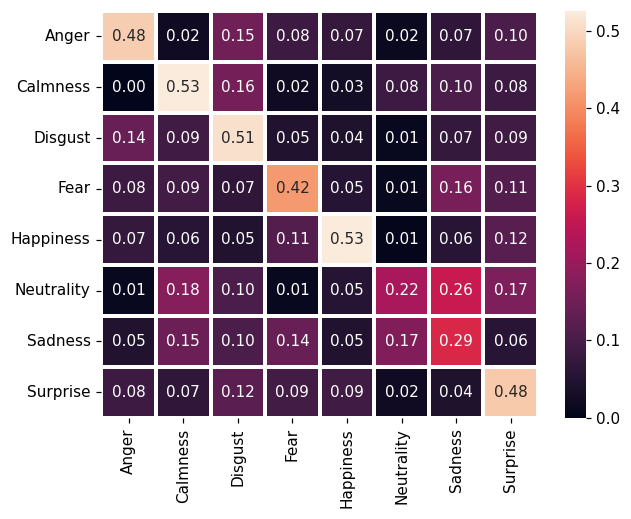

               Anger  Calmness   Disgust      Fear  Happiness  Neutrality  \
Anger       0.484375  0.020833  0.151042  0.083333   0.072917    0.015625   
Calmness    0.000000  0.526042  0.156250  0.020833   0.026042    0.083333   
Disgust     0.140625  0.088542  0.510417  0.046875   0.041667    0.010417   
Fear        0.083333  0.093750  0.067708  0.416667   0.052083    0.010417   
Happiness   0.072917  0.057292  0.046875  0.114583   0.526042    0.005208   
Neutrality  0.010417  0.177083  0.104167  0.010417   0.052083    0.218750   
Sadness     0.046875  0.145833  0.104167  0.140625   0.046875    0.171875   
Surprise    0.083333  0.067708  0.125000  0.093750   0.088542    0.020833   

             Sadness  Surprise  
Anger       0.067708  0.104167  
Calmness    0.104167  0.083333  
Disgust     0.072917  0.088542  
Fear        0.161458  0.114583  
Happiness   0.057292  0.119792  
Neutrality  0.260417  0.166667  
Sadness     0.286458  0.057292  
Surprise    0.041667  0.479167  
Saving co

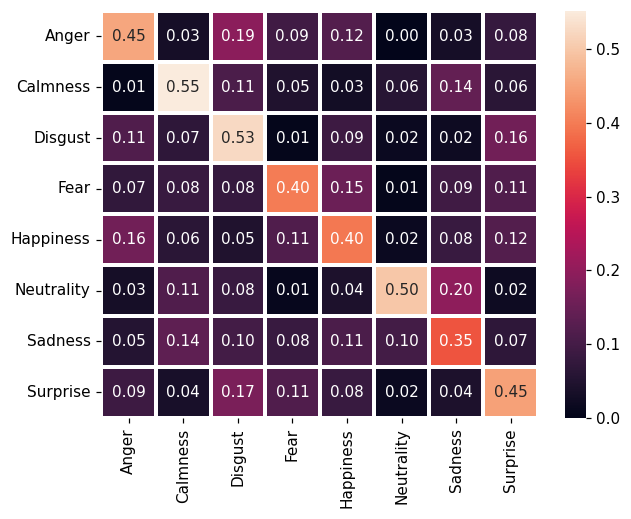

               Anger  Calmness   Disgust      Fear  Happiness  Neutrality  \
Anger       0.453125  0.031250  0.192708  0.093750   0.119792    0.000000   
Calmness    0.005208  0.552083  0.109375  0.046875   0.026042    0.057292   
Disgust     0.114583  0.067708  0.526042  0.005208   0.088542    0.015625   
Fear        0.072917  0.083333  0.078125  0.401042   0.151042    0.005208   
Happiness   0.161458  0.062500  0.046875  0.114583   0.395833    0.015625   
Neutrality  0.031250  0.114583  0.083333  0.010417   0.041667    0.500000   
Sadness     0.052083  0.135417  0.098958  0.083333   0.109375    0.098958   
Surprise    0.088542  0.036458  0.171875  0.114583   0.083333    0.015625   

             Sadness  Surprise  
Anger       0.031250  0.078125  
Calmness    0.140625  0.062500  
Disgust     0.020833  0.161458  
Fear        0.093750  0.114583  
Happiness   0.083333  0.119792  
Neutrality  0.197917  0.020833  
Sadness     0.354167  0.067708  
Surprise    0.041667  0.447917  
Saving co

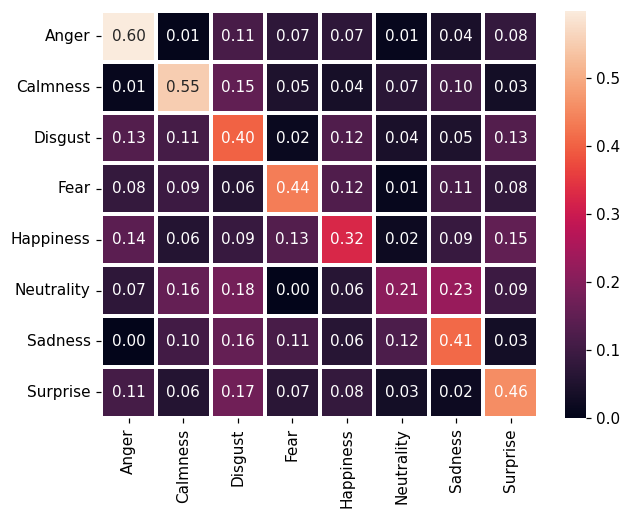

               Anger  Calmness   Disgust      Fear  Happiness  Neutrality  \
Anger       0.598958  0.005208  0.114583  0.072917   0.072917    0.010417   
Calmness    0.010417  0.552083  0.151042  0.046875   0.036458    0.067708   
Disgust     0.130208  0.109375  0.401042  0.015625   0.125000    0.041667   
Fear        0.083333  0.093750  0.057292  0.437500   0.125000    0.010417   
Happiness   0.140625  0.057292  0.088542  0.130208   0.322917    0.020833   
Neutrality  0.072917  0.156250  0.177083  0.000000   0.062500    0.208333   
Sadness     0.000000  0.104167  0.156250  0.114583   0.062500    0.119792   
Surprise    0.109375  0.057292  0.171875  0.067708   0.083333    0.031250   

             Sadness  Surprise  
Anger       0.041667  0.083333  
Calmness    0.104167  0.031250  
Disgust     0.046875  0.130208  
Fear        0.114583  0.078125  
Happiness   0.088542  0.151042  
Neutrality  0.229167  0.093750  
Sadness     0.411458  0.031250  
Surprise    0.020833  0.458333  
Saving co

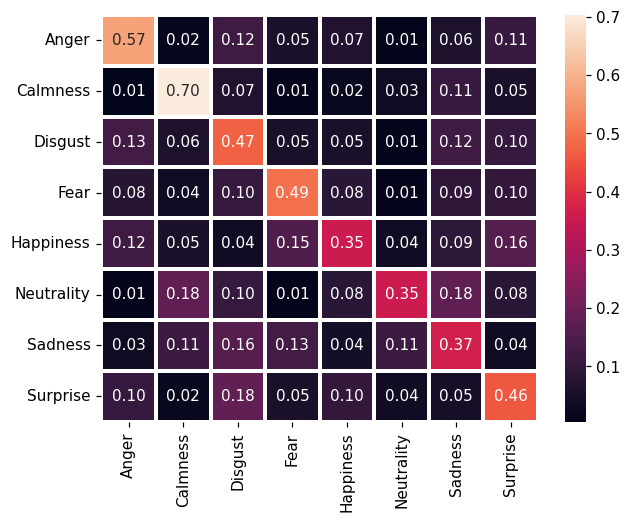

               Anger  Calmness   Disgust      Fear  Happiness  Neutrality  \
Anger       0.572917  0.015625  0.119792  0.052083   0.067708    0.005208   
Calmness    0.005208  0.703125  0.067708  0.010417   0.020833    0.031250   
Disgust     0.130208  0.057292  0.473958  0.052083   0.052083    0.005208   
Fear        0.078125  0.036458  0.104167  0.494792   0.083333    0.010417   
Happiness   0.119792  0.052083  0.036458  0.151042   0.354167    0.036458   
Neutrality  0.010417  0.177083  0.104167  0.010417   0.083333    0.354167   
Sadness     0.031250  0.114583  0.161458  0.130208   0.041667    0.114583   
Surprise    0.104167  0.020833  0.182292  0.052083   0.098958    0.036458   

             Sadness  Surprise  
Anger       0.057292  0.109375  
Calmness    0.109375  0.052083  
Disgust     0.125000  0.104167  
Fear        0.093750  0.098958  
Happiness   0.088542  0.161458  
Neutrality  0.177083  0.083333  
Sadness     0.369792  0.036458  
Surprise    0.046875  0.458333  
Saving co

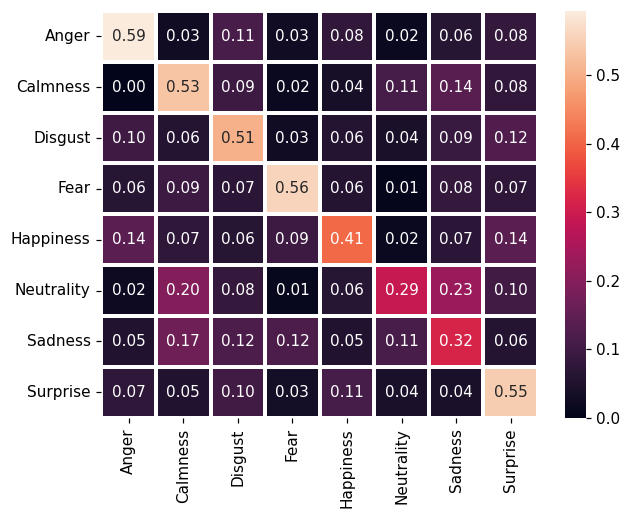

               Anger  Calmness   Disgust      Fear  Happiness  Neutrality  \
Anger       0.593750  0.026042  0.114583  0.026042   0.078125    0.015625   
Calmness    0.000000  0.531250  0.093750  0.015625   0.036458    0.109375   
Disgust     0.098958  0.057292  0.505208  0.026042   0.057292    0.041667   
Fear        0.062500  0.093750  0.067708  0.557292   0.057292    0.005208   
Happiness   0.140625  0.072917  0.062500  0.093750   0.406250    0.015625   
Neutrality  0.020833  0.197917  0.083333  0.010417   0.062500    0.291667   
Sadness     0.052083  0.166667  0.119792  0.119792   0.052083    0.114583   
Surprise    0.072917  0.052083  0.104167  0.031250   0.109375    0.041667   

             Sadness  Surprise  
Anger       0.062500  0.083333  
Calmness    0.135417  0.078125  
Disgust     0.088542  0.125000  
Fear        0.083333  0.072917  
Happiness   0.067708  0.140625  
Neutrality  0.229167  0.104167  
Sadness     0.317708  0.057292  
Surprise    0.041667  0.546875  
Saving co

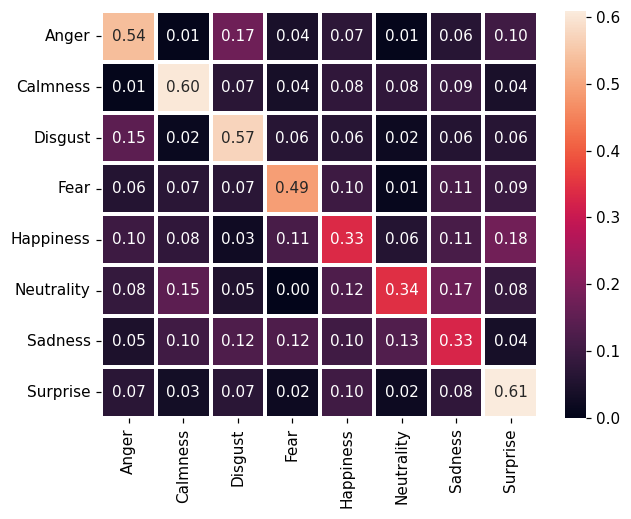

               Anger  Calmness   Disgust      Fear  Happiness  Neutrality  \
Anger       0.536458  0.005208  0.171875  0.041667   0.072917    0.005208   
Calmness    0.005208  0.604167  0.067708  0.036458   0.078125    0.078125   
Disgust     0.145833  0.015625  0.572917  0.062500   0.062500    0.020833   
Fear        0.057292  0.067708  0.067708  0.489583   0.098958    0.010417   
Happiness   0.098958  0.078125  0.026042  0.114583   0.333333    0.057292   
Neutrality  0.083333  0.145833  0.052083  0.000000   0.125000    0.343750   
Sadness     0.046875  0.104167  0.125000  0.125000   0.104167    0.130208   
Surprise    0.067708  0.031250  0.067708  0.020833   0.104167    0.020833   

             Sadness  Surprise  
Anger       0.062500  0.104167  
Calmness    0.088542  0.041667  
Disgust     0.057292  0.062500  
Fear        0.114583  0.093750  
Happiness   0.114583  0.177083  
Neutrality  0.166667  0.083333  
Sadness     0.328125  0.036458  
Surprise    0.078125  0.609375  
Saving co

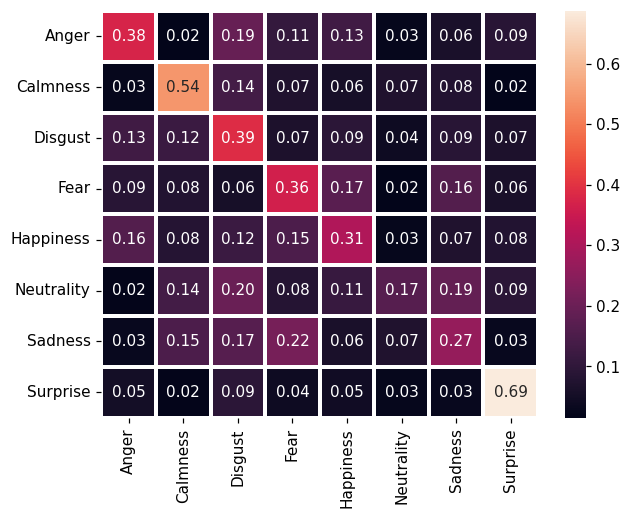

               Anger  Calmness   Disgust      Fear  Happiness  Neutrality  \
Anger       0.375000  0.015625  0.192708  0.109375   0.130208    0.026042   
Calmness    0.026042  0.541667  0.135417  0.072917   0.057292    0.072917   
Disgust     0.130208  0.119792  0.390625  0.067708   0.093750    0.041667   
Fear        0.088542  0.078125  0.057292  0.364583   0.171875    0.015625   
Happiness   0.161458  0.083333  0.119792  0.151042   0.307292    0.026042   
Neutrality  0.020833  0.135417  0.197917  0.083333   0.114583    0.166667   
Sadness     0.031250  0.151042  0.166667  0.218750   0.062500    0.072917   
Surprise    0.052083  0.020833  0.093750  0.041667   0.046875    0.026042   

             Sadness  Surprise  
Anger       0.062500  0.088542  
Calmness    0.078125  0.015625  
Disgust     0.088542  0.067708  
Fear        0.161458  0.062500  
Happiness   0.072917  0.078125  
Neutrality  0.187500  0.093750  
Sadness     0.265625  0.031250  
Surprise    0.031250  0.687500  
Saving co

In [14]:
Emotions = ['happy','neutral','sad','calm','fear','disgust','surprised']

for emotion_label in Emotions:
    # Relabeling and normilizing
    y_true = np.zeros((len(y)))
    y_true[np.squeeze(y.values==emotion_label)] = 1
    y_true[y_true==0] = -1

    X_data = X.values
    X_norm = (X_data - X_data.mean(axis=0)) / X_data.std(axis=0)
    y_reg = copy.copy(y_true)

    try:
        Rank = np.load(f'../../data/lda/Lasso_Ranking_lda_{emotion_label}_result.npy')
    except:
        print("We need to compute LASSO ranking")

        # LASSO ranking
        Lasso_model = linear_model.Lasso()
        Npt = 200
        coeffs = np.zeros((X_norm.shape[1],Npt))
        lambda_ = np.logspace(-12.5, 0.3, Npt)
        i = 0
        for lamb in tqdm(lambda_):
            Lasso_model = linear_model.Lasso(alpha=lamb, max_iter=20000)
            Lasso_model.fit(X_norm,y_reg)
            coeffs[:,i] = Lasso_model.coef_
            i = i + 1

        plt.figure(dpi=110)
        plt.plot(coeffs.T)
        plt.xlabel('$\lambda$ number')
        plt.ylabel('Coeffs')
        plt.show()

        Rank_lasso = []
        for i in range(coeffs.shape[1]-1,-1,-1):
            withdraw_features = np.nonzero(coeffs[:,i])[0];
            something_new = np.setdiff1d(withdraw_features, Rank_lasso)
            if len(something_new):
                for ii in range(len(something_new)):
                    Rank_lasso.append(something_new[ii])
        
        np.save(f'../../data/lda/Lasso_Ranking_lda_{emotion_label}_result.npy', Rank_lasso)    # .npy extension is added if not given
        Rank = np.load(f'../../data/lda/Lasso_Ranking_lda_{emotion_label}_result.npy')

    try:
        uar_lda = np.load(f'../../data/lda/feature_lda_uar_total_{emotion_label}.npy')
    except:
        # LOSO accuracy estimation
        uar_lda = []
        uar_best = 0
        ind_best = 0
        for k in tqdm(range(1,len(Rank)+1)):
            feature_inds = Rank[:k]
            uar,_,_ = LDA_eval(X, pd.DataFrame(y_reg), feature_inds, ID)    
            uar_lda.append(uar)
            if (uar>uar_best):
                uar_best = uar
                ind_best = k-1
                print('Iter = ', k, f' UAR = {uar:.4f}' )
        
        fig,ax=plt.subplots(figsize=(7,4),dpi=100)
        plt.rcParams.update({'font.size': 14})
        plt.plot(uar_lda,marker='o', linestyle='dashed')
        plt.text(ind_best, uar_best+0.01, f'{uar_best:.3f}')
        plt.xlabel('Number of features')
        plt.ylabel('UAR')
        plt.title('LDA classifier')
        plt.ylim([0.45, 1.00])
        plt.show()
        
        print(f'uar_best = {uar_best:.8f}')
        print('best uar (LDA) = ', np.max(uar_lda), 'Number of features = ', np.argmax(uar_lda))

        np.save(f'../../data/lda/feature_lda_uar_total_{emotion_label}.npy', uar_lda)    # .npy extension is added if not given
        uar_lda = np.load(f'../../data/lda/feature_lda_uar_total_{emotion_label}.npy')
    
    # image_name = 'figures\\ACC_LDA_.jpg'
    # fig.savefig(image_name, bbox_inches='tight', pad_inches = 0.2)

    try:
        feature_ind = np.load(f'../../data/lda/feature_LDA_idx_{emotion_label}.npy')
    except:
        # Backward step selection
        ind_best = np.argmax(uar_lda)
        [acc_final,feature_ind] = back_step_selection_lda(X, pd.DataFrame(y_reg), Rank[:ind_best+1],ID)
        np.save(f'../../data/lda/feature_LDA_idx_{emotion_label}.npy', feature_ind)    # .npy extension is added if not given
        feature_ind = np.load(f'../../data/lda/feature_LDA_idx_{emotion_label}.npy')

    # 5-fold CV (selected feature space)
    group_members= data_loader.get_k_fold_group_member()
    X_new = pd.DataFrame(X_norm[:,feature_ind])
    X_k_folds, y_k_folds = data_loader.get_custom_k_folds(X_new, y, ID, group_members)
    model = LinearDiscriminantAnalysis()
    UAR,y_pred,y_true = model_training.estimate_model(model, X_k_folds, y_k_folds)
    plotting_utils.plot_confusion_matrix_eng(y_true, y_pred,image_path=f'confusion_matrix_LDA_{emotion_label}.jpg')
    print(f'UAR final = {UAR:.3f}')

# Backward step selection

In [4]:
def back_step_selection_lda(X,y,feature_ind, ID):
# BACK_STEP_SELECTION Automatic procedure of feature selection

#basic version
   # acc_mu_curr = LDA_LOSO_eval(X,y,feature_ind, ID)
   acc_mu_curr,_,_ = LDA_eval(X, y, feature_ind, ID)
   some_feature_droped = True
   while (some_feature_droped):
      print('NEW ROUND')
      acc_up = -np.ones_like(feature_ind).astype(np.double)
      for i in range(len(feature_ind)):
         cur_inds = np.setdiff1d(feature_ind,feature_ind[i])
         # acc_mu = LDA_LOSO_eval(X,y,cur_inds, ID)
         acc_mu,_,_ = LDA_eval(X, y, cur_inds, ID)                  
         
         if (acc_mu>=acc_mu_curr):
            acc_up[i] = acc_mu-acc_mu_curr
            print(f'Iter #{i}: {acc_mu:.3f} <-> {acc_mu_curr:.3f}')
            
      m_val = np.max(acc_up)
      m_ind = np.argmax(acc_up)
      
      if (m_val>=0):
         print(f'Withdraw feature #{m_ind}, added accracy {m_val}')
         feature_ind = np.setdiff1d(feature_ind,feature_ind[m_ind]);
         some_feature_droped = True       
         # new basic version
         # acc_mu_curr = LDA_LOSO_eval(X,y,feature_ind, ID)
         acc_mu_curr,_,_ = LDA_eval(X, y, feature_ind, ID)
      else:
         acc_final = acc_mu_curr
         some_feature_droped = False

   return acc_final, feature_ind

# 5-fold CV (full feature space)

In [6]:
group_members= data_loader.get_k_fold_group_member()
X_new = pd.DataFrame(X_norm)
X_k_folds, y_k_folds = data_loader.get_custom_k_folds(X_new, y, ID, group_members)

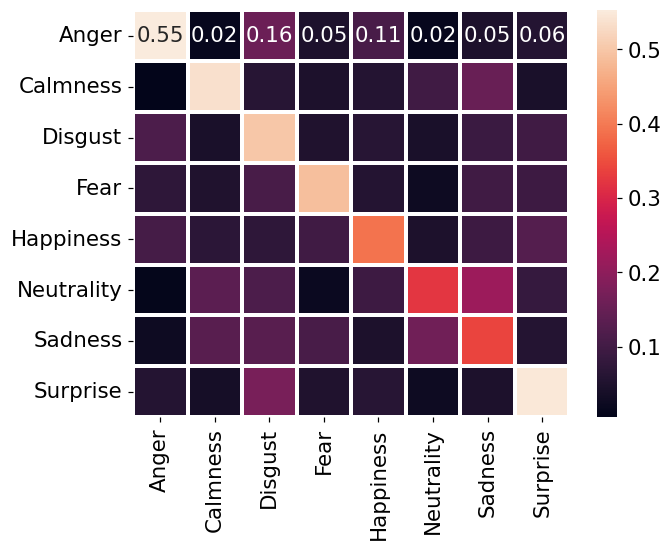

               Anger  Calmness   Disgust      Fear  Happiness  Neutrality  \
Anger       0.552083  0.015625  0.156250  0.046875   0.109375    0.015625   
Calmness    0.005208  0.536458  0.062500  0.046875   0.057292    0.098958   
Disgust     0.114583  0.041667  0.500000  0.052083   0.062500    0.041667   
Fear        0.072917  0.052083  0.109375  0.489583   0.057292    0.026042   
Happiness   0.104167  0.067708  0.072917  0.098958   0.390625    0.046875   
Neutrality  0.010417  0.135417  0.114583  0.020833   0.093750    0.322917   
Sadness     0.026042  0.130208  0.130208  0.109375   0.046875    0.161458   
Surprise    0.057292  0.036458  0.171875  0.052083   0.062500    0.026042   

             Sadness  Surprise  
Anger       0.046875  0.057292  
Calmness    0.151042  0.041667  
Disgust     0.088542  0.098958  
Fear        0.098958  0.093750  
Happiness   0.093750  0.125000  
Neutrality  0.218750  0.083333  
Sadness     0.338542  0.057292  
Surprise    0.046875  0.546875  
Saving co

In [8]:
model = LinearDiscriminantAnalysis()

UAR,y_pred,y_true = model_training.estimate_model(model, X_k_folds, y_k_folds)
# Confusion matrix
plotting_utils.plot_confusion_matrix_eng(y_true, y_pred,image_path=f'../../data/lda/confusion_matrix_LDA_full.jpg')
print(f'UAR final = {UAR:.3f}')

# Joint subset of features

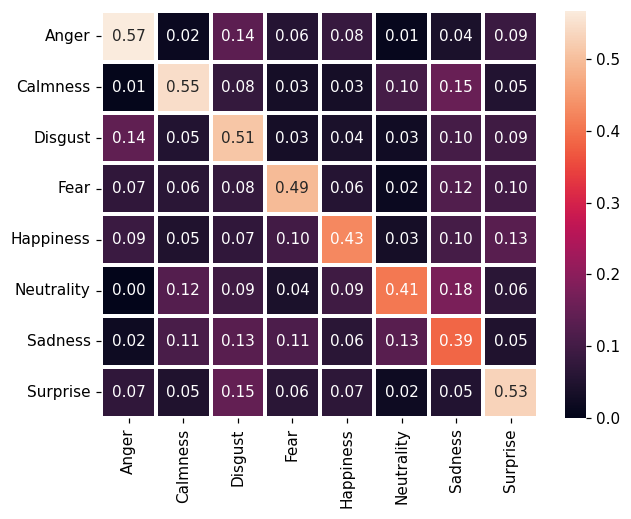

               Anger  Calmness   Disgust      Fear  Happiness  Neutrality  \
Anger       0.567708  0.015625  0.135417  0.057292   0.083333    0.010417   
Calmness    0.005208  0.546875  0.078125  0.031250   0.031250    0.104167   
Disgust     0.140625  0.052083  0.510417  0.031250   0.041667    0.026042   
Fear        0.072917  0.062500  0.078125  0.494792   0.057292    0.015625   
Happiness   0.088542  0.046875  0.072917  0.098958   0.427083    0.031250   
Neutrality  0.000000  0.125000  0.093750  0.041667   0.093750    0.406250   
Sadness     0.020833  0.109375  0.130208  0.114583   0.062500    0.130208   
Surprise    0.072917  0.046875  0.145833  0.062500   0.067708    0.020833   

             Sadness  Surprise  
Anger       0.041667  0.088542  
Calmness    0.151042  0.052083  
Disgust     0.104167  0.093750  
Fear        0.119792  0.098958  
Happiness   0.104167  0.130208  
Neutrality  0.177083  0.062500  
Sadness     0.385417  0.046875  
Surprise    0.052083  0.531250  
Saving co

In [5]:
Emotions = ['happy','neutral','sad','calm','fear','disgust','surprised']
feature_joint_inds = []

for Emotion_label in Emotions:
    feature_ind = np.load(f'../../data/lda/feature_LDA_idx_{Emotion_label}.npy')
    feature_joint_inds = np.unique(np.concatenate((feature_joint_inds, feature_ind)))

feature_joint_inds = feature_joint_inds.astype(int)

group_members= data_loader.get_k_fold_group_member()
X_new = pd.DataFrame(X_norm[:,feature_joint_inds])
X_k_folds, y_k_folds = data_loader.get_custom_k_folds(X_new, y, ID, group_members)
model = LinearDiscriminantAnalysis()
UAR,y_pred,y_true = model_training.estimate_model(model, X_k_folds, y_k_folds)
plotting_utils.plot_confusion_matrix_eng(y_true, y_pred,image_path=f'../../data/lda/confusion_matrix_LDA_joint_features.jpg')
print(f'UAR final = {UAR:.3f}')

### coeffs_with_lambda_num

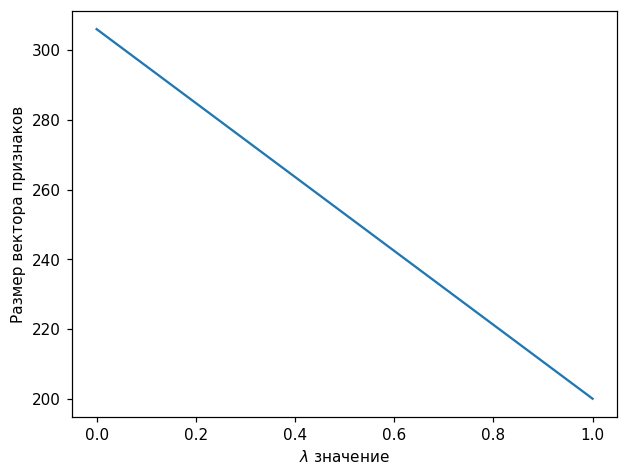

In [13]:
Npt = 200
coeffs = np.array((X_norm.shape[1],Npt))
lambda_ = np.logspace(-12.5, 0.3, Npt)
plt.figure(dpi=110)
plt.plot(coeffs.T)
plt.xlabel('$\lambda$ значение')
plt.ylabel('Размер вектора признаков')
plt.savefig('../../data/lda/coeffs_with_lambda_num.jpg')